In [1]:
import numpy as np
import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(False)  # Habilita la ejecución ansiosa

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Input, TimeDistributed, BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import os
from keras.models import load_model
from keras.callbacks import Callback
import json
import io
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from comet_ml import Experiment
import optuna

c:\Users\Ing. Biologica\Documents\GitHub\SABI_2025_Molina\entorno_sabi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# establecer semilla
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Partición por sujeto

In [33]:
# Levanto los datos
# Directorio de los datos
ruta_datos = "../data/"
# Cargo datos
os.chdir(ruta_datos) # me situo en el directorio

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado: '../data/'

In [4]:
# levanto todos los datasets
cant_ds = 11
list_ds = []
for i in range(cant_ds):
  ds = tf.data.Dataset.load("dataset_GI_sin_reposo_650_stride5_crudo_sub"+str(i))
  list_ds.append(ds)

## Crear partición por sujeto

In [7]:
# Esta función crea los conjuntos de train, val y test según los índices de folds que se les pase para cada uno
def generar_particion(list_ds, ind_train, ind_val, ind_test):

  ds_train = list_ds[ind_train[0]]
  ind_train = ind_train[1:]  # porque inicializo el dataset con este

  for i in ind_train:
    ds_train = ds_train.concatenate(list_ds[i])

  ds_val = list_ds[ind_val[0]]
  ind_val = ind_val[1:]  # porque inicializo el dataset con este
  for i in ind_val:
    ds_val = ds_val.concatenate(list_ds[i])

  ds_test = list_ds[ind_test[0]]
  ind_test = ind_test[1:]  # porque inicializo el dataset con este
  for i in ind_test:
    ds_test = ds_test.concatenate(list_ds[i])

  return ds_train, ds_val, ds_test

In [10]:
# genero indices aleatorios para particion
# con test
indices = np.random.permutation(11)
ind_train = indices[:7]
ind_val = indices[7:9]
ind_test = indices[9:11]

# # sin test
# ind_train = indices[:9]
# ind_val = indices[9:11]

print(ind_train)
print(ind_val)
print(ind_test)

# también puedo hardcodear los indices si quiero una partición en específico

ds_train_base, ds_val_base, ds_test_base = generar_particion(list_ds, ind_train, ind_val, ind_test)

[ 6  2  8  7  9  5 10]
[3 0]
[4 1]


Creo un directorio para guardar los modelos y otras cosas relativos al entrenamiento de este modelo.

### Todos los sujetos a test

In [11]:
# esto lo uso cuando quiero que todos los sujetos vayan a test (estretagia 1)
def generar_particion_test(list_ds):
  # Esta funcion recibe como entrada una lista con los folds, donde cada fold es un dataset,
  # y devuelve un conjunto de train, val y test:
  # val: 30 hasta 40, train: resto.

  # Armo el conjunto de train
  ind_train = list(np.arange(11))

  ind_train.pop(0)  # porque inicializo el dataset con este
  ds_train = list_ds[0]
  for i in ind_train:
    ds_train = ds_train.concatenate(list_ds[i])

  return ds_train
ds_test_base = generar_particion_test(list_ds)

# Partición por repetición

Uso el fold 1 para test, y el 4 para validación. Es decir, todas las repeticiones 1 para test, y todas las repeticiones 4 para validación.

In [3]:
# Directorio de los datos
ruta_datos = "../data/"
# Cargo datos
os.chdir(ruta_datos) # me situo en el directorio

In [4]:
# levanto todos los datasets
cant_ds = 11  # esta es la cantidad de sujetos
cant_rep = 6
list_ds = []

# si quiero entrenar para todos los sujetos, el for itera en cant_ds
# si quiero usar un sujeto en particular (estrategia 4), lo especifico en sujeto_part
sujeto_part = 6

for i in range(sujeto_part ,sujeto_part+1): #cant_ds

  ds_reps = []
  for j in range(cant_rep):
    # ds_reps_j = tf.data.Dataset.load("dataset_E1_selected_sin_reposo_crudo_sub"+str(i)+"x_rep_fold_rep_"+str(j))
    ds_reps_j = tf.data.Dataset.load("dataset_E1_DB3_crudo_normalizado_sub"+str(i)+"_weighted_fold_rep_"+str(j))
    ds_reps.append(ds_reps_j)
  list_ds.append(ds_reps)

c:\Users\Ing. Biologica\Documents\GitHub\PFG_Molina\entorno_PFG_Molina\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [5]:
folds_rep = [[], [], [], [], [], []]

for i in list_ds:
  for j in range(len(i)):
    folds_rep[j].append(i[j])

# TODO mejorar. por ahora lo hago hardcodeado para cada fold
fold0_rep = folds_rep[0]
fold1_rep = folds_rep[1]
fold2_rep = folds_rep[2]
fold3_rep = folds_rep[3]
fold4_rep = folds_rep[4]
fold5_rep = folds_rep[5]

# fold 0
ds0_all = fold0_rep[0]
for i in range(1, len(fold0_rep)):
  ds0_all = ds0_all.concatenate(fold0_rep[i])

# fold 1
ds_test_base = fold1_rep[0]
for i in range(1, len(fold1_rep)):
  ds_test_base = ds_test_base.concatenate(fold1_rep[i])

# fold 2
ds2_all = fold2_rep[0]
for i in range(1, len(fold2_rep)):
  ds2_all = ds2_all.concatenate(fold2_rep[i])

# fold 3
ds3_all = fold3_rep[0]
for i in range(1, len(fold3_rep)):
  ds3_all = ds3_all.concatenate(fold3_rep[i])

# fold 4
ds_val_base = fold4_rep[0]
for i in range(1, len(fold4_rep)):
  ds_val_base = ds_val_base.concatenate(fold4_rep[i])

# fold 5
ds5_all = fold5_rep[0]
for i in range(1, len(fold5_rep)):
  ds5_all = ds5_all.concatenate(fold5_rep[i])
  
ds2_all = ds2_all.concatenate(ds3_all)
ds2_all = ds2_all.concatenate(ds0_all)

# lo llamo ds_train
ds_train_base = ds2_all.concatenate(ds5_all)

# Accedo a experimento guardado o creo experimento

In [20]:
# elijo el directorio donde quiero guardar los resultados del experimento actual
nombre_exp = "GI_estrategia4_sujeto5"
ruta_experimento = "../clasificacion_sujetos_amputacion/experimentos/" + nombre_exp
os.makedirs(ruta_experimento, exist_ok=True) # me fijo si existe, si no, lo creo
os.chdir(ruta_experimento) # me situo en el directorio

## Guardar o levantar índices de folds
Solo sirve para cuando trabajo por sujeto

In [ ]:
# guardo los indices
joblib.dump(ind_train, 'ind_train_' + nombre_exp)
joblib.dump(ind_val, 'ind_val_' + nombre_exp)
joblib.dump(ind_test, 'ind_test_' + nombre_exp)

In [ ]:
# levanto los indices
ind_train = joblib.load("ind_train_" + nombre_exp)
ind_val = joblib.load("ind_val_" + nombre_exp)
ind_test = joblib.load("ind_test_" + nombre_exp)

ds_train_base, ds_val_base, ds_test_base = generar_particion(list_ds, ind_train, ind_val, ind_test)

print(ind_train)
print(ind_val)
print(ind_test)

# Preparación de datos

In [21]:
# Directorio de los datos
ruta_datos = "../../../data/"   # salgo de nombre_exp -- experimentos -- clasificacion_sujetos_amputacion -- data
# Cargo datos
os.chdir(ruta_datos) # me situo en el directorio

In [22]:
# observo la forma del primer elemento del conjunto de test
for x, y, z in ds_test_base.take(1):
  input_shape = x.shape
  label_shape = y.shape
  label = y
print('Input shape:', input_shape)
print('Label shape:', label_shape)
print('Label', label)
num_classes = 10

Input shape: (650, 12)
Label shape: ()
Label tf.Tensor(0, shape=(), dtype=int32)


In [23]:
# Función para convertir etiquetas a formato one-hot
def one_hot_encode(data, label, weight):
    label = tf.one_hot(label, depth=num_classes, dtype=tf.int8)
    return data, label, weight

In [24]:
# funciones de acondicionamiento de los datos
BATCH_SIZE = 16
def preparar_ds(ds):
  ds = ds.map(one_hot_encode) # paso las clases a una codificacion one hot
  ds = ds.shuffle(buffer_size=ds.cardinality()) # hago un shuffle de los datos
  ds = ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE) # armo batches y cargo en memoria la cantidad de datos optima, listos para ser utilizados
  return ds

ds_train = preparar_ds(ds_train_base)
ds_val = preparar_ds(ds_val_base)
ds_test = preparar_ds(ds_test_base)


# Fine tuning
Sólo se ejecuta para las estrategias en las que se hace fine tunning

Levanto particiones de datos

In [ ]:
# si quiero usar un modelo entrenado en DB2
nombre_exp = "GI_estrategia3_lr_fixed_particion3"
ruta_experimento = "/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3/" + nombre_exp
os.chdir(ruta_experimento) # me situo en el directorio

In [ ]:
# levanto los indices
ind_train = joblib.load("ind_train_" + nombre_exp)
ind_val = joblib.load("ind_val_" + nombre_exp)
ind_test = joblib.load("ind_test_" + nombre_exp)

ds_train_base, ds_val_base, ds_test_base = generar_particion(list_ds, ind_train, ind_val, ind_test)

Me sitúo en la ruta donde está el modelo entrenado

In [ ]:
# si quiero usar un modelo entrenado en DB2
nombre_exp = "GI_estrategia1_normalizado_DB2_particion1"
ruta_experimento = "/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/modelos/" + nombre_exp
os.chdir(ruta_experimento) # me situo en el directorio

Levanto el pkl del modelo

In [ ]:
model = joblib.load(nombre_exp + ".pkl")

In [ ]:
# Antes de ejecutar esto, es necesario ejecutar la celda que define el modelo
lr = 0.00008

# Congelar todas las capas menos la última
for layer in model.layers[:-1]:
    layer.trainable = False

# Volver a compilar el modelo
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'], weighted_metrics=['accuracy'])

Creo el directorio para guardar el experimento

In [ ]:
# elijo el directorio donde quiero guardar los resultados del experimento actual
nombre_exp = "GI_estrategia5_normalizado_particion1_sujeto10"
ruta_experimento = "/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB3/" + nombre_exp
os.makedirs(ruta_experimento, exist_ok=True) # me fijo si existe, si no, lo creo
# os.chdir(ruta_experimento) # me situo en el directorio

In [ ]:
# vuelvo al directorio de los datos
# Directorio de los datos
%cd "/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/DB3"

/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/src/ronda_gestos_puntuales/DB3


**Tengo que ir a la parte de preparación de datos y luego a entrenar el modelo por primera vez**

# Diseño e implementación de RNN

## Optimización de arquitectura e hiperparámetros
Esto es para la prueba de concepto de la optimización de una RNN para un sujeto específico, siguiendo la estrategia 4

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
class EarlyStoppingOnInstability(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.05, patience=1):
        super(EarlyStoppingOnInstability, self).__init__()
        self.threshold = threshold  # Umbral para detectar inestabilidad
        self.patience = patience    # Número de épocas de inestabilidad antes de detenerse
        self.wait = 0
        self.best_loss = np.inf
        self.previous_weights = None  # Guardar los pesos de la época anterior

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("val_loss")

        if current_loss is None:
            return  # No se especificó val_loss en las métricas

        # Si la pérdida mejora, actualizar la mejor pérdida y guardar los pesos actuales
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.previous_weights = self.model.get_weights()  # Guardar los pesos como "mejores"
            self.wait = 0  # Reiniciar el contador de paciencia
        # Detecta inestabilidad solo si la pérdida aumenta más allá del umbral desde la mejor pérdida
        elif current_loss > self.best_loss + self.threshold:
            self.wait += 1
            print(f"Inestabilidad detectada en epoch {epoch + 1}. Conteo de paciencia: {self.wait}")

        # Detiene el entrenamiento y restaura los pesos de la época anterior a la inestabilidad
        if self.wait >= self.patience:
            print("Deteniendo entrenamiento debido a inestabilidad en la pérdida de validación.")
            self.model.stop_training = True
            if self.previous_weights is not None:
                self.model.set_weights(self.previous_weights)  # Restaurar los pesos de la época anterior

# Usar el callback en el entrenamiento
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

def objective(trial):
    # Definición de parámetros a optimizar
    n_neurons = trial.suggest_int("n_neurons", 32, 50)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)

    input_shape = (650, 12)

    # Definir el modelo
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(n_neurons, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    # Entrenar el modelo con los callbacks
    model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=10,
        callbacks=[EarlyStoppingOnInstability(threshold=0.05, patience=1), early_stopping]
    )

    # Evaluar el modelo en el conjunto de validación
    score = model.evaluate(ds_val)

    return score[1]

# Configurar y optimizar el estudio con Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))




[I 2024-11-12 18:36:22,422] A new study created in memory with name: no-name-21f1634b-f41a-4684-9d6c-fb78bde95f0d
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.0815 - loss: 2.3129 - val_accuracy: 0.1992 - val_loss: 2.3129
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.0943 - loss: 2.3100 - val_accuracy: 0.1966 - val_loss: 2.3112
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0925 - loss: 2.3080 - val_accuracy: 0.1874 - val_loss: 2.3099
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.0945 - loss: 2.3056 - val_accuracy: 0.1481 - val_loss: 2.3088
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.0974 - loss: 2.3034 - val_accuracy: 0.1180 - val_loss: 2.3080
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.1033 - loss: 2.3028 - val_accuracy: 0.1180 - val_loss: 2.3073
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1195 - loss: 2.3022 - val_accuracy: 0.1193 - val_loss: 2.3067
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1347 - loss: 2.3019 - val_acc

[I 2024-11-12 18:37:19,908] Trial 0 finished with value: 0.11009174585342407 and parameters: {'n_neurons': 47, 'learning_rate': 1.7204595188608553e-05}. Best is trial 0 with value: 0.11009174585342407.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.1233 - loss: 2.3050 - val_accuracy: 0.1638 - val_loss: 2.3010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.1581 - loss: 2.2911 - val_accuracy: 0.1664 - val_loss: 2.3021
Epoch 3/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2080 - loss: 2.2099Inestabilidad detectada en epoch 3. Conteo de paciencia: 1
Deteniendo entrenamiento debido a inestabilidad en la pérdida de validación.
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2080 - loss: 2.2097 - val_accuracy: 0.1035 - val_loss: 2.3654
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1584 - loss: 2.2995


[I 2024-11-12 18:37:41,788] Trial 1 finished with value: 0.16382700204849243 and parameters: {'n_neurons': 36, 'learning_rate': 0.0002753350790847459}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1099 - loss: 2.3085 - val_accuracy: 0.1612 - val_loss: 2.3045
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.1541 - loss: 2.2921 - val_accuracy: 0.1664 - val_loss: 2.3030
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.2332 - loss: 2.2515 - val_accuracy: 0.1062 - val_loss: 2.3003
Epoch 4/10
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3614 - loss: 2.0462Inestabilidad detectada en epoch 4. Conteo de paciencia: 1
Deteniendo entrenamiento debido a inestabilidad en la pérdida de validación.
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.3615 - loss: 2.0456 - val_accuracy: 0.0839 - val_loss: 2.3667
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1090 - loss: 2.3052


[I 2024-11-12 18:38:03,116] Trial 2 finished with value: 0.10615989565849304 and parameters: {'n_neurons': 33, 'learning_rate': 0.00031966356609382793}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.0931 - loss: 2.3108 - val_accuracy: 0.1048 - val_loss: 2.3105
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1077 - loss: 2.3042 - val_accuracy: 0.1048 - val_loss: 2.3096
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.0988 - loss: 2.3059 - val_accuracy: 0.1048 - val_loss: 2.3089
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0927 - loss: 2.3060


[I 2024-11-12 18:38:20,944] Trial 3 finished with value: 0.10484927892684937 and parameters: {'n_neurons': 41, 'learning_rate': 2.7933299780446654e-05}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1050 - loss: 2.3159 - val_accuracy: 0.0996 - val_loss: 2.3112
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.1004 - loss: 2.3107 - val_accuracy: 0.0996 - val_loss: 2.3098
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1061 - loss: 2.3102 - val_accuracy: 0.0996 - val_loss: 2.3087
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0857 - loss: 2.3151


[I 2024-11-12 18:38:37,762] Trial 4 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 43, 'learning_rate': 1.178761459115204e-05}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1264 - loss: 2.3122 - val_accuracy: 0.0760 - val_loss: 2.3061
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.1204 - loss: 2.3068 - val_accuracy: 0.0826 - val_loss: 2.3055
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1371 - loss: 2.3029 - val_accuracy: 0.0852 - val_loss: 2.3051
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0833 - loss: 2.3048


[I 2024-11-12 18:38:54,062] Trial 5 finished with value: 0.07601572573184967 and parameters: {'n_neurons': 42, 'learning_rate': 1.034207788102318e-05}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.1011 - loss: 2.3070 - val_accuracy: 0.0996 - val_loss: 2.3082
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0970 - loss: 2.3057 - val_accuracy: 0.0996 - val_loss: 2.3074
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1028 - loss: 2.3008 - val_accuracy: 0.0996 - val_loss: 2.3069
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1164 - loss: 2.3077


[I 2024-11-12 18:39:10,483] Trial 6 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 32, 'learning_rate': 3.5836166447502544e-05}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.0958 - loss: 2.3052 - val_accuracy: 0.0996 - val_loss: 2.3023
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.1006 - loss: 2.2942 - val_accuracy: 0.0236 - val_loss: 2.3015
Epoch 3/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2089 - loss: 2.2697Inestabilidad detectada en epoch 3. Conteo de paciencia: 1
Deteniendo entrenamiento debido a inestabilidad en la pérdida de validación.
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2093 - loss: 2.2693 - val_accuracy: 0.0983 - val_loss: 2.3613
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0958 - loss: 2.3020


[I 2024-11-12 18:39:33,033] Trial 7 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 37, 'learning_rate': 0.0001924274113824928}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1239 - loss: 2.3018 - val_accuracy: 0.0944 - val_loss: 2.2929
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.2242 - loss: 2.2216 - val_accuracy: 0.0328 - val_loss: 2.2975
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2413 - loss: 2.1924Inestabilidad detectada en epoch 3. Conteo de paciencia: 1
Deteniendo entrenamiento debido a inestabilidad en la pérdida de validación.
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.2412 - loss: 2.1926 - val_accuracy: 0.0931 - val_loss: 2.4367
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0918 - loss: 2.2933


[I 2024-11-12 18:39:54,899] Trial 8 finished with value: 0.09436435252428055 and parameters: {'n_neurons': 47, 'learning_rate': 0.0008310665349741203}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1061 - loss: 2.3107 - val_accuracy: 0.0996 - val_loss: 2.3095
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1124 - loss: 2.3026 - val_accuracy: 0.0996 - val_loss: 2.3062
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.0959 - loss: 2.3003 - val_accuracy: 0.0996 - val_loss: 2.3045
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1067 - loss: 2.3071


[I 2024-11-12 18:40:12,595] Trial 9 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 35, 'learning_rate': 6.341210272159586e-05}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.1382 - loss: 2.2979 - val_accuracy: 0.0000e+00 - val_loss: 2.3093
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2518 - loss: 2.2397 - val_accuracy: 0.0066 - val_loss: 2.2949
Epoch 3/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2650 - loss: 2.1102Inestabilidad detectada en epoch 3. Conteo de paciencia: 1
Deteniendo entrenamiento debido a inestabilidad en la pérdida de validación.
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2655 - loss: 2.1095 - val_accuracy: 0.1415 - val_loss: 2.4276
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0000e+00 - loss: 2.3035


[I 2024-11-12 18:40:33,814] Trial 10 finished with value: 0.0 and parameters: {'n_neurons': 38, 'learning_rate': 0.0009242767233409217}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0925 - loss: 2.3125 - val_accuracy: 0.0996 - val_loss: 2.3014
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1043 - loss: 2.2951 - val_accuracy: 0.0996 - val_loss: 2.2989
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.1764 - loss: 2.2740 - val_accuracy: 0.1022 - val_loss: 2.3477
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1111 - loss: 2.2966


[I 2024-11-12 18:40:51,714] Trial 11 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 50, 'learning_rate': 0.00017292943912971634}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.0847 - loss: 2.3106 - val_accuracy: 0.0721 - val_loss: 2.3062
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1845 - loss: 2.2756 - val_accuracy: 0.1009 - val_loss: 2.3405
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.1633 - loss: 2.2356 - val_accuracy: 0.0524 - val_loss: 2.3175
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0643 - loss: 2.3064


[I 2024-11-12 18:41:08,023] Trial 12 finished with value: 0.07208388298749924 and parameters: {'n_neurons': 46, 'learning_rate': 0.0003957264107299137}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1069 - loss: 2.3069 - val_accuracy: 0.1035 - val_loss: 2.3075
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.1205 - loss: 2.2999 - val_accuracy: 0.1035 - val_loss: 2.3060
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.1118 - loss: 2.2974 - val_accuracy: 0.1035 - val_loss: 2.3050
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1074 - loss: 2.3066


[I 2024-11-12 18:41:30,749] Trial 13 finished with value: 0.10353866219520569 and parameters: {'n_neurons': 39, 'learning_rate': 9.3044487439987e-05}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.0980 - loss: 2.3045 - val_accuracy: 0.0944 - val_loss: 2.3049
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1011 - loss: 2.3083 - val_accuracy: 0.0944 - val_loss: 2.3040
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.0930 - loss: 2.3049 - val_accuracy: 0.0944 - val_loss: 2.3033
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0967 - loss: 2.2992


[I 2024-11-12 18:41:47,585] Trial 14 finished with value: 0.09436435252428055 and parameters: {'n_neurons': 45, 'learning_rate': 2.6121546676201563e-05}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1058 - loss: 2.3069 - val_accuracy: 0.0996 - val_loss: 2.3067
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.1089 - loss: 2.3021 - val_accuracy: 0.0996 - val_loss: 2.3048
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1062 - loss: 2.2991 - val_accuracy: 0.1153 - val_loss: 2.3039
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1049 - loss: 2.3054


[I 2024-11-12 18:42:04,313] Trial 15 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 49, 'learning_rate': 5.9364716881885156e-05}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.1054 - loss: 2.2984 - val_accuracy: 0.0682 - val_loss: 2.3045
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.2041 - loss: 2.2605 - val_accuracy: 0.0223 - val_loss: 2.3409
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2119 - loss: 2.1623 - val_accuracy: 0.0537 - val_loss: 2.3094
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0733 - loss: 2.3011


[I 2024-11-12 18:42:26,231] Trial 16 finished with value: 0.0681520327925682 and parameters: {'n_neurons': 40, 'learning_rate': 0.00042498149877592134}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1002 - loss: 2.3051 - val_accuracy: 0.0996 - val_loss: 2.3047
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.1123 - loss: 2.2947 - val_accuracy: 0.1507 - val_loss: 2.3044
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.2182 - loss: 2.2721 - val_accuracy: 0.1009 - val_loss: 2.3320
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1112 - loss: 2.3030


[I 2024-11-12 18:42:43,956] Trial 17 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 36, 'learning_rate': 0.00018364486112650225}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.1012 - loss: 2.3074 - val_accuracy: 0.0996 - val_loss: 2.3064
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0940 - loss: 2.3062 - val_accuracy: 0.0996 - val_loss: 2.3053
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.0948 - loss: 2.3042 - val_accuracy: 0.0996 - val_loss: 2.3043
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1232 - loss: 2.2996


[I 2024-11-12 18:43:07,363] Trial 18 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 44, 'learning_rate': 1.9109474017011497e-05}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.0961 - loss: 2.3217 - val_accuracy: 0.0996 - val_loss: 2.3108
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1013 - loss: 2.3054 - val_accuracy: 0.0839 - val_loss: 2.3079
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1456 - loss: 2.2969 - val_accuracy: 0.0000e+00 - val_loss: 2.3070
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1122 - loss: 2.3076


[I 2024-11-12 18:43:28,844] Trial 19 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 34, 'learning_rate': 9.942398292922945e-05}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.0881 - loss: 2.3079 - val_accuracy: 0.0996 - val_loss: 2.3036
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.0913 - loss: 2.3029 - val_accuracy: 0.0996 - val_loss: 2.3020
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1000 - loss: 2.3003 - val_accuracy: 0.0996 - val_loss: 2.3010
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0985 - loss: 2.3037


[I 2024-11-12 18:43:51,359] Trial 20 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 48, 'learning_rate': 5.026179795460675e-05}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.0960 - loss: 2.3077 - val_accuracy: 0.1166 - val_loss: 2.3032
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.1269 - loss: 2.2921 - val_accuracy: 0.0118 - val_loss: 2.2983
Epoch 3/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2611 - loss: 2.2327Inestabilidad detectada en epoch 3. Conteo de paciencia: 1
Deteniendo entrenamiento debido a inestabilidad en la pérdida de validación.
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.2609 - loss: 2.2323 - val_accuracy: 0.1284 - val_loss: 2.4192
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1341 - loss: 2.3043


[I 2024-11-12 18:44:14,685] Trial 21 finished with value: 0.11664482206106186 and parameters: {'n_neurons': 32, 'learning_rate': 0.00035548433995927496}. Best is trial 1 with value: 0.16382700204849243.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1071 - loss: 2.3040 - val_accuracy: 0.1691 - val_loss: 2.2982
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.2043 - loss: 2.2588 - val_accuracy: 0.1206 - val_loss: 2.3438
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2093 - loss: 2.1996 - val_accuracy: 0.1088 - val_loss: 2.2936
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1679 - loss: 2.2976


[I 2024-11-12 18:44:35,742] Trial 22 finished with value: 0.16906946897506714 and parameters: {'n_neurons': 32, 'learning_rate': 0.0006321491340487479}. Best is trial 22 with value: 0.16906946897506714.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.1221 - loss: 2.3030 - val_accuracy: 0.0917 - val_loss: 2.3160
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.1809 - loss: 2.2610 - val_accuracy: 0.0773 - val_loss: 2.3211
Epoch 3/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2484 - loss: 2.1770Inestabilidad detectada en epoch 3. Conteo de paciencia: 1
Deteniendo entrenamiento debido a inestabilidad en la pérdida de validación.
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2485 - loss: 2.1768 - val_accuracy: 0.1782 - val_loss: 2.3676
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0891 - loss: 2.3164


[I 2024-11-12 18:44:57,972] Trial 23 finished with value: 0.0917431190609932 and parameters: {'n_neurons': 32, 'learning_rate': 0.0006093112369991806}. Best is trial 22 with value: 0.16906946897506714.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.0978 - loss: 2.3124 - val_accuracy: 0.0996 - val_loss: 2.3038
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.1200 - loss: 2.2985 - val_accuracy: 0.1022 - val_loss: 2.2994
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2267 - loss: 2.2491 - val_accuracy: 0.1455 - val_loss: 2.3091
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0868 - loss: 2.3066


[I 2024-11-12 18:45:14,719] Trial 24 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 34, 'learning_rate': 0.0003134703103387311}. Best is trial 22 with value: 0.16906946897506714.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.1145 - loss: 2.3029 - val_accuracy: 0.1153 - val_loss: 2.3042
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.1728 - loss: 2.2903 - val_accuracy: 0.0157 - val_loss: 2.3414
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2176 - loss: 2.2534 - val_accuracy: 0.1822 - val_loss: 2.3084
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1197 - loss: 2.3048


[I 2024-11-12 18:45:36,675] Trial 25 finished with value: 0.11533420532941818 and parameters: {'n_neurons': 36, 'learning_rate': 0.000588682257564668}. Best is trial 22 with value: 0.16906946897506714.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1067 - loss: 2.3031 - val_accuracy: 0.0970 - val_loss: 2.3030
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1642 - loss: 2.2979 - val_accuracy: 0.0406 - val_loss: 2.3017
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2565 - loss: 2.2877 - val_accuracy: 0.1193 - val_loss: 2.2694
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2158 - loss: 2.2245 - val_accuracy: 0.1114 - val_loss: 2.2887
Epoch 5/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2987 - loss: 2.1212Inestabilidad detectada en epoch 5. Conteo de paciencia: 1
Deteniendo entrenamiento debido a inestabilidad en la pérdida de validación.
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2987 - loss: 2.1209 - val_accuracy: 0.1402 - val_loss: 2.5542
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1368 - loss: 2.2658


[I 2024-11-12 18:46:09,032] Trial 26 finished with value: 0.11926605552434921 and parameters: {'n_neurons': 32, 'learning_rate': 0.0002623423976341885}. Best is trial 22 with value: 0.16906946897506714.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.1166 - loss: 2.3101 - val_accuracy: 0.0996 - val_loss: 2.3017
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.1656 - loss: 2.2929 - val_accuracy: 0.0878 - val_loss: 2.2942
Epoch 3/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2214 - loss: 2.2467Inestabilidad detectada en epoch 3. Conteo de paciencia: 1
Deteniendo entrenamiento debido a inestabilidad en la pérdida de validación.
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.2212 - loss: 2.2465 - val_accuracy: 0.0786 - val_loss: 2.3518
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1024 - loss: 2.3013


[I 2024-11-12 18:46:31,666] Trial 27 finished with value: 0.09960681200027466 and parameters: {'n_neurons': 34, 'learning_rate': 0.0002547500943022977}. Best is trial 22 with value: 0.16906946897506714.


Number of finished trials: 28
Best trial:
  Value: 0.16906946897506714
  Params: 
    n_neurons: 32
    learning_rate: 0.0006321491340487479


In [ ]:
def objective(trial):
    # Definimos los parámetros a optimizar
    n_neurons = trial.suggest_int("n_neurons", 16, 96)
    lr = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)

    input_shape = (650, 12)

    # Definir el modelo
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(n_neurons, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy'],
        weighted_metrics=['accuracy']
    )

    # Configurar el callback de early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Monitorea la pérdida de validación
        patience=3,          # Número de épocas sin mejora antes de detenerse
        restore_best_weights=True  # Restaurar los mejores pesos obtenidos
    )

    # Entrenar el modelo con early stopping
    model.fit(ds_train, validation_data=ds_val, epochs=80, callbacks=[early_stopping])

    # Evaluar el modelo en el conjunto de validación
    score = model.evaluate(ds_val)

    return score[1]  # Devuelve la precisión en el conjunto de validación

# Configurar y optimizar el estudio con Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30) # , timeout=6000

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-12 14:52:33,990] A new study created in memory with name: no-name-e606cc46-aabd-4cc2-b918-f0e300276d08


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.1978 - loss: 2.1280 - weighted_accuracy: 0.1987 - val_accuracy: 0.5788 - val_loss: 1.3835 - val_weighted_accuracy: 0.5815
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5780 - loss: 1.2824 - weighted_accuracy: 0.5790 - val_accuracy: 0.5656 - val_loss: 1.0783 - val_weighted_accuracy: 0.5649
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6216 - loss: 1.0855 - weighted_accuracy: 0.6251 - val_accuracy: 0.6041 - val_loss: 1.0444 - val_weighted_accuracy: 0.6001
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7021 - loss: 0.9116 - weighted_accuracy: 0.7016 - val_accuracy: 0.7100 - val_loss: 0.8324 - val_weighted_accuracy: 0.7116
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7429 - loss: 0.7879 - weighted_accuracy: 0.7447 - val_accuracy: 0.6847 - val_loss: 0.8807 - val_weighted_accuracy: 0.6871
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step -

[I 2024-11-12 14:54:13,383] Trial 0 finished with value: 0.7605294585227966 and parameters: {'n_neurons': 46, 'learning_rate': 0.0007512461082395287}. Best is trial 0 with value: 0.7605294585227966.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.0947 - loss: 2.3070 - weighted_accuracy: 0.0920 - val_accuracy: 0.1059 - val_loss: 2.3073 - val_weighted_accuracy: 0.1029
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0942 - loss: 2.3084 - weighted_accuracy: 0.0916 - val_accuracy: 0.1059 - val_loss: 2.3061 - val_weighted_accuracy: 0.1029
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.1096 - loss: 2.2990 - weighted_accuracy: 0.1066 - val_accuracy: 0.1059 - val_loss: 2.3050 - val_weighted_accuracy: 0.1029
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.1068 - loss: 2.3001 - weighted_accuracy: 0.1039 - val_accuracy: 0.1059 - val_loss: 2.3039 - val_weighted_accuracy: 0.1029
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.1013 - loss: 2.3017 - weighted_accuracy: 0.0985 - val_accuracy: 0.1059 - val_loss: 2.3028 - val_weighted_accuracy: 0.1029
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step

[I 2024-11-12 15:05:33,835] Trial 1 finished with value: 0.322503000497818 and parameters: {'n_neurons': 83, 'learning_rate': 2.5040720717049803e-06}. Best is trial 0 with value: 0.7605294585227966.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1237 - loss: 2.2618 - weighted_accuracy: 0.1250 - val_accuracy: 0.2792 - val_loss: 1.9658 - val_weighted_accuracy: 0.2856
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.3267 - loss: 1.8087 - weighted_accuracy: 0.3307 - val_accuracy: 0.3129 - val_loss: 1.5801 - val_weighted_accuracy: 0.3124
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4146 - loss: 1.5792 - weighted_accuracy: 0.4149 - val_accuracy: 0.4621 - val_loss: 1.3968 - val_weighted_accuracy: 0.4605
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4895 - loss: 1.3820 - weighted_accuracy: 0.4898 - val_accuracy: 0.4705 - val_loss: 1.2975 - val_weighted_accuracy: 0.4697
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6176 - loss: 1.2298 - weighted_accuracy: 0.6181 - val_accuracy: 0.3069 - val_loss: 1.6729 - val_weighted_accuracy: 0.3013
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step -

[I 2024-11-12 15:07:05,510] Trial 2 finished with value: 0.5691937208175659 and parameters: {'n_neurons': 64, 'learning_rate': 0.000259451977353084}. Best is trial 0 with value: 0.7605294585227966.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.1364 - loss: 2.2835 - weighted_accuracy: 0.1380 - val_accuracy: 0.1998 - val_loss: 1.9866 - val_weighted_accuracy: 0.2076
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.2151 - loss: 1.9993 - weighted_accuracy: 0.2228 - val_accuracy: 0.2347 - val_loss: 1.8149 - val_weighted_accuracy: 0.2368
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2400 - loss: 1.7938 - weighted_accuracy: 0.2468 - val_accuracy: 0.3045 - val_loss: 1.6409 - val_weighted_accuracy: 0.3055
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.3744 - loss: 1.5912 - weighted_accuracy: 0.3778 - val_accuracy: 0.3442 - val_loss: 1.5491 - val_weighted_accuracy: 0.3446
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4041 - loss: 1.4901 - weighted_accuracy: 0.4079 - val_accuracy: 0.4850 - val_loss: 1.3911 - val_weighted_accuracy: 0.4853
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step 

[I 2024-11-12 15:09:52,730] Trial 3 finished with value: 0.7605294585227966 and parameters: {'n_neurons': 91, 'learning_rate': 0.00011744312668784121}. Best is trial 0 with value: 0.7605294585227966.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1050 - loss: 2.3109 - weighted_accuracy: 0.1030 - val_accuracy: 0.1011 - val_loss: 2.3143 - val_weighted_accuracy: 0.0993
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1066 - loss: 2.3080 - weighted_accuracy: 0.1047 - val_accuracy: 0.1011 - val_loss: 2.3124 - val_weighted_accuracy: 0.0993
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.1055 - loss: 2.3059 - weighted_accuracy: 0.1036 - val_accuracy: 0.1011 - val_loss: 2.3105 - val_weighted_accuracy: 0.0993
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.0975 - loss: 2.3043 - weighted_accuracy: 0.0957 - val_accuracy: 0.1011 - val_loss: 2.3088 - val_weighted_accuracy: 0.0993
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.1059 - loss: 2.3011 - weighted_accuracy: 0.1039 - val_accuracy: 0.1011 - val_loss: 2.3071 - val_weighted_accuracy: 0.0993
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - 

[I 2024-11-12 15:18:04,449] Trial 4 finished with value: 0.3297232389450073 and parameters: {'n_neurons': 21, 'learning_rate': 8.890815987298609e-06}. Best is trial 0 with value: 0.7605294585227966.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.1905 - loss: 2.3058 - weighted_accuracy: 0.1882 - val_accuracy: 0.0108 - val_loss: 2.2923 - val_weighted_accuracy: 0.0109
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.2095 - loss: 2.2816 - weighted_accuracy: 0.2080 - val_accuracy: 0.2924 - val_loss: 2.2600 - val_weighted_accuracy: 0.2955
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3623 - loss: 2.2154 - weighted_accuracy: 0.3645 - val_accuracy: 0.2178 - val_loss: 2.0662 - val_weighted_accuracy: 0.2254
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.2805 - loss: 1.9636 - weighted_accuracy: 0.2848 - val_accuracy: 0.2347 - val_loss: 1.9635 - val_weighted_accuracy: 0.2354
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3261 - loss: 1.8098 - weighted_accuracy: 0.3249 - val_accuracy: 0.3225 - val_loss: 1.7767 - val_weighted_accuracy: 0.3221
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - 

[I 2024-11-12 15:23:28,099] Trial 5 finished with value: 0.701564371585846 and parameters: {'n_neurons': 59, 'learning_rate': 5.198364939649151e-05}. Best is trial 0 with value: 0.7605294585227966.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.0337 - loss: 2.3133 - weighted_accuracy: 0.0351 - val_accuracy: 0.0000e+00 - val_loss: 2.3087 - val_weighted_accuracy: 0.0000e+00
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.0350 - loss: 2.3118 - weighted_accuracy: 0.0364 - val_accuracy: 0.0000e+00 - val_loss: 2.3084 - val_weighted_accuracy: 0.0000e+00
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.0376 - loss: 2.3060 - weighted_accuracy: 0.0391 - val_accuracy: 0.0000e+00 - val_loss: 2.3081 - val_weighted_accuracy: 0.0000e+00
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.0331 - loss: 2.3125 - weighted_accuracy: 0.0344 - val_accuracy: 0.0000e+00 - val_loss: 2.3078 - val_weighted_accuracy: 0.0000e+00
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.0361 - loss: 2.3119 - weighted_accuracy: 0.0374 - val_accuracy: 0.0000e+00 - val_loss: 2.3075 - val_weighted_accuracy: 0.0000e+00
Epoch 6/80
210/

[I 2024-11-12 15:33:15,155] Trial 6 finished with value: 0.09386281669139862 and parameters: {'n_neurons': 36, 'learning_rate': 1.007181249019737e-06}. Best is trial 0 with value: 0.7605294585227966.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.1032 - loss: 2.3045 - weighted_accuracy: 0.1025 - val_accuracy: 0.0999 - val_loss: 2.2906 - val_weighted_accuracy: 0.0991
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.0998 - loss: 2.2907 - weighted_accuracy: 0.0991 - val_accuracy: 0.1937 - val_loss: 2.2715 - val_weighted_accuracy: 0.1968
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.2135 - loss: 2.2621 - weighted_accuracy: 0.2141 - val_accuracy: 0.2792 - val_loss: 2.0174 - val_weighted_accuracy: 0.2792
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.2816 - loss: 1.9916 - weighted_accuracy: 0.2818 - val_accuracy: 0.2094 - val_loss: 1.9559 - val_weighted_accuracy: 0.2105
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.3115 - loss: 1.9553 - weighted_accuracy: 0.3114 - val_accuracy: 0.3105 - val_loss: 1.8939 - val_weighted_accuracy: 0.3104
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step 

[I 2024-11-12 15:40:02,161] Trial 7 finished with value: 0.6738868951797485 and parameters: {'n_neurons': 86, 'learning_rate': 3.560941340202435e-05}. Best is trial 0 with value: 0.7605294585227966.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.1302 - loss: 2.2844 - weighted_accuracy: 0.1291 - val_accuracy: 0.2082 - val_loss: 2.0201 - val_weighted_accuracy: 0.2093
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.2255 - loss: 1.9134 - weighted_accuracy: 0.2267 - val_accuracy: 0.3682 - val_loss: 1.5817 - val_weighted_accuracy: 0.3734
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3898 - loss: 1.5263 - weighted_accuracy: 0.3940 - val_accuracy: 0.5439 - val_loss: 1.3232 - val_weighted_accuracy: 0.5488
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.3992 - loss: 1.6678 - weighted_accuracy: 0.4033 - val_accuracy: 0.2996 - val_loss: 2.5164 - val_weighted_accuracy: 0.3022
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2963 - loss: 2.0838 - weighted_accuracy: 0.2995 - val_accuracy: 0.5596 - val_loss: 1.4463 - val_weighted_accuracy: 0.5641
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step

[I 2024-11-12 15:40:57,731] Trial 8 finished with value: 0.5439229607582092 and parameters: {'n_neurons': 69, 'learning_rate': 0.00016642737724642572}. Best is trial 0 with value: 0.7605294585227966.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.1899 - loss: 2.2231 - weighted_accuracy: 0.1947 - val_accuracy: 0.4513 - val_loss: 1.6082 - val_weighted_accuracy: 0.4539
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4500 - loss: 1.5385 - weighted_accuracy: 0.4511 - val_accuracy: 0.4789 - val_loss: 1.2849 - val_weighted_accuracy: 0.4805
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5444 - loss: 1.3469 - weighted_accuracy: 0.5463 - val_accuracy: 0.5006 - val_loss: 1.7177 - val_weighted_accuracy: 0.5034
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.3996 - loss: 1.6262 - weighted_accuracy: 0.4011 - val_accuracy: 0.6546 - val_loss: 1.1641 - val_weighted_accuracy: 0.6552
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6053 - loss: 1.1131 - weighted_accuracy: 0.6064 - val_accuracy: 0.6378 - val_loss: 0.9623 - val_weighted_accuracy: 0.6402
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step -

[I 2024-11-12 15:42:20,113] Trial 9 finished with value: 0.9518651962280273 and parameters: {'n_neurons': 57, 'learning_rate': 0.00040924729908465787}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.1584 - loss: 2.1921 - weighted_accuracy: 0.1592 - val_accuracy: 0.3502 - val_loss: 1.5489 - val_weighted_accuracy: 0.3489
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4683 - loss: 1.4845 - weighted_accuracy: 0.4685 - val_accuracy: 0.6282 - val_loss: 1.1074 - val_weighted_accuracy: 0.6287
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6553 - loss: 1.0635 - weighted_accuracy: 0.6559 - val_accuracy: 0.6462 - val_loss: 0.8923 - val_weighted_accuracy: 0.6479
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6704 - loss: 1.0156 - weighted_accuracy: 0.6698 - val_accuracy: 0.6486 - val_loss: 0.8365 - val_weighted_accuracy: 0.6496
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7132 - loss: 0.8611 - weighted_accuracy: 0.7145 - val_accuracy: 0.6715 - val_loss: 0.7532 - val_weighted_accuracy: 0.6726
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step -

[I 2024-11-12 15:44:01,247] Trial 10 finished with value: 0.7352586984634399 and parameters: {'n_neurons': 39, 'learning_rate': 0.0009450788290989089}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1887 - loss: 2.1089 - weighted_accuracy: 0.1907 - val_accuracy: 0.5897 - val_loss: 1.3807 - val_weighted_accuracy: 0.5882
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.4622 - loss: 1.3110 - weighted_accuracy: 0.4621 - val_accuracy: 0.5909 - val_loss: 1.0792 - val_weighted_accuracy: 0.5955
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6495 - loss: 1.0360 - weighted_accuracy: 0.6518 - val_accuracy: 0.4982 - val_loss: 0.9590 - val_weighted_accuracy: 0.4993
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6730 - loss: 0.9034 - weighted_accuracy: 0.6723 - val_accuracy: 0.7605 - val_loss: 0.8218 - val_weighted_accuracy: 0.7605
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7844 - loss: 0.6855 - weighted_accuracy: 0.7855 - val_accuracy: 0.7064 - val_loss: 0.7446 - val_weighted_accuracy: 0.7059
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step -

[I 2024-11-12 15:45:50,881] Trial 11 finished with value: 0.7990372776985168 and parameters: {'n_neurons': 44, 'learning_rate': 0.000996929056786262}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.1549 - loss: 2.2463 - weighted_accuracy: 0.1572 - val_accuracy: 0.4910 - val_loss: 1.6581 - val_weighted_accuracy: 0.4938
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4261 - loss: 1.5770 - weighted_accuracy: 0.4267 - val_accuracy: 0.6438 - val_loss: 1.2924 - val_weighted_accuracy: 0.6431
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5726 - loss: 1.2387 - weighted_accuracy: 0.5711 - val_accuracy: 0.4813 - val_loss: 1.1402 - val_weighted_accuracy: 0.4790
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4764 - loss: 1.4736 - weighted_accuracy: 0.4760 - val_accuracy: 0.3935 - val_loss: 1.6337 - val_weighted_accuracy: 0.3932
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.3993 - loss: 1.5399 - weighted_accuracy: 0.3975 - val_accuracy: 0.5584 - val_loss: 1.2290 - val_weighted_accuracy: 0.5540
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step 

[I 2024-11-12 15:47:27,640] Trial 12 finished with value: 0.6594464778900146 and parameters: {'n_neurons': 51, 'learning_rate': 0.0004185375808425666}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.1041 - loss: 2.3138 - weighted_accuracy: 0.1083 - val_accuracy: 0.1023 - val_loss: 2.3026 - val_weighted_accuracy: 0.1064
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.1216 - loss: 2.2924 - weighted_accuracy: 0.1259 - val_accuracy: 0.2816 - val_loss: 2.2713 - val_weighted_accuracy: 0.2846
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.2645 - loss: 2.2376 - weighted_accuracy: 0.2669 - val_accuracy: 0.2599 - val_loss: 2.0113 - val_weighted_accuracy: 0.2624
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.2873 - loss: 2.0178 - weighted_accuracy: 0.2909 - val_accuracy: 0.2984 - val_loss: 2.0075 - val_weighted_accuracy: 0.3018
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2990 - loss: 1.9925 - weighted_accuracy: 0.3023 - val_accuracy: 0.2599 - val_loss: 1.9304 - val_weighted_accuracy: 0.2624
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step 

[I 2024-11-12 15:54:37,209] Trial 13 finished with value: 0.7099879384040833 and parameters: {'n_neurons': 24, 'learning_rate': 9.71352051121574e-05}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.0963 - loss: 2.3054 - weighted_accuracy: 0.0949 - val_accuracy: 0.1011 - val_loss: 2.2975 - val_weighted_accuracy: 0.0997
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.1091 - loss: 2.3007 - weighted_accuracy: 0.1080 - val_accuracy: 0.1011 - val_loss: 2.2924 - val_weighted_accuracy: 0.0997
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.1225 - loss: 2.2938 - weighted_accuracy: 0.1219 - val_accuracy: 0.1035 - val_loss: 2.2873 - val_weighted_accuracy: 0.1022
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.1402 - loss: 2.2886 - weighted_accuracy: 0.1402 - val_accuracy: 0.1661 - val_loss: 2.2818 - val_weighted_accuracy: 0.1673
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.1377 - loss: 2.2816 - weighted_accuracy: 0.1385 - val_accuracy: 0.1793 - val_loss: 2.2752 - val_weighted_accuracy: 0.1811
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - 

[I 2024-11-12 16:04:25,115] Trial 14 finished with value: 0.3297232389450073 and parameters: {'n_neurons': 73, 'learning_rate': 1.2671844019488254e-05}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1500 - loss: 2.2274 - weighted_accuracy: 0.1523 - val_accuracy: 0.3189 - val_loss: 1.7646 - val_weighted_accuracy: 0.3183
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3899 - loss: 1.6914 - weighted_accuracy: 0.3893 - val_accuracy: 0.4765 - val_loss: 1.3402 - val_weighted_accuracy: 0.4788
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4950 - loss: 1.3535 - weighted_accuracy: 0.4970 - val_accuracy: 0.5499 - val_loss: 1.1130 - val_weighted_accuracy: 0.5473
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5618 - loss: 1.1754 - weighted_accuracy: 0.5620 - val_accuracy: 0.6498 - val_loss: 1.1219 - val_weighted_accuracy: 0.6525
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5322 - loss: 1.1558 - weighted_accuracy: 0.5326 - val_accuracy: 0.6270 - val_loss: 0.9514 - val_weighted_accuracy: 0.6301
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step -

[I 2024-11-12 16:05:34,496] Trial 15 finished with value: 0.6269554495811462 and parameters: {'n_neurons': 35, 'learning_rate': 0.00044608596369001}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.1768 - loss: 2.2010 - weighted_accuracy: 0.1772 - val_accuracy: 0.2082 - val_loss: 2.0156 - val_weighted_accuracy: 0.2093
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.2571 - loss: 1.9668 - weighted_accuracy: 0.2576 - val_accuracy: 0.4284 - val_loss: 1.5085 - val_weighted_accuracy: 0.4286
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4949 - loss: 1.4245 - weighted_accuracy: 0.4976 - val_accuracy: 0.4501 - val_loss: 1.2174 - val_weighted_accuracy: 0.4493
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6247 - loss: 1.1452 - weighted_accuracy: 0.6255 - val_accuracy: 0.2395 - val_loss: 3.3158 - val_weighted_accuracy: 0.2457
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.3001 - loss: 2.1055 - weighted_accuracy: 0.3051 - val_accuracy: 0.5981 - val_loss: 1.7338 - val_weighted_accuracy: 0.5990
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step

[I 2024-11-12 16:06:37,746] Trial 16 finished with value: 0.4500601589679718 and parameters: {'n_neurons': 54, 'learning_rate': 0.0009058813328814289}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.1675 - loss: 2.2768 - weighted_accuracy: 0.1659 - val_accuracy: 0.2274 - val_loss: 1.8439 - val_weighted_accuracy: 0.2286
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.3697 - loss: 1.7157 - weighted_accuracy: 0.3701 - val_accuracy: 0.3406 - val_loss: 1.4036 - val_weighted_accuracy: 0.3422
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5441 - loss: 1.3611 - weighted_accuracy: 0.5450 - val_accuracy: 0.5644 - val_loss: 1.2174 - val_weighted_accuracy: 0.5687
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6208 - loss: 1.1925 - weighted_accuracy: 0.6217 - val_accuracy: 0.5223 - val_loss: 1.1976 - val_weighted_accuracy: 0.5298
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6500 - loss: 1.1136 - weighted_accuracy: 0.6525 - val_accuracy: 0.6570 - val_loss: 1.0075 - val_weighted_accuracy: 0.6614
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step 

[I 2024-11-12 16:09:08,034] Trial 17 finished with value: 0.7148014307022095 and parameters: {'n_neurons': 44, 'learning_rate': 0.00029407842404239275}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.1140 - loss: 2.3190 - weighted_accuracy: 0.1121 - val_accuracy: 0.1011 - val_loss: 2.2997 - val_weighted_accuracy: 0.0993
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.1147 - loss: 2.2957 - weighted_accuracy: 0.1127 - val_accuracy: 0.1011 - val_loss: 2.2725 - val_weighted_accuracy: 0.0993
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2340 - loss: 2.2654 - weighted_accuracy: 0.2307 - val_accuracy: 0.2094 - val_loss: 2.2095 - val_weighted_accuracy: 0.2047
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3812 - loss: 2.1754 - weighted_accuracy: 0.3743 - val_accuracy: 0.1685 - val_loss: 2.0188 - val_weighted_accuracy: 0.1647
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.3063 - loss: 2.0203 - weighted_accuracy: 0.3010 - val_accuracy: 0.2479 - val_loss: 1.9953 - val_weighted_accuracy: 0.2435
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step

[I 2024-11-12 16:17:31,887] Trial 18 finished with value: 0.6666666865348816 and parameters: {'n_neurons': 28, 'learning_rate': 7.114206863266606e-05}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.1020 - loss: 2.3062 - weighted_accuracy: 0.1018 - val_accuracy: 0.0963 - val_loss: 2.2983 - val_weighted_accuracy: 0.0961
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0942 - loss: 2.2986 - weighted_accuracy: 0.0941 - val_accuracy: 0.1637 - val_loss: 2.2893 - val_weighted_accuracy: 0.1663
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.1081 - loss: 2.2920 - weighted_accuracy: 0.1085 - val_accuracy: 0.1986 - val_loss: 2.2784 - val_weighted_accuracy: 0.2026
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.1665 - loss: 2.2804 - weighted_accuracy: 0.1687 - val_accuracy: 0.3971 - val_loss: 2.2602 - val_weighted_accuracy: 0.4030
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2718 - loss: 2.2545 - weighted_accuracy: 0.2770 - val_accuracy: 0.1998 - val_loss: 2.1485 - val_weighted_accuracy: 0.2076
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step 

[I 2024-11-12 16:26:02,583] Trial 19 finished with value: 0.6353790760040283 and parameters: {'n_neurons': 75, 'learning_rate': 2.2997570177056913e-05}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.1591 - loss: 2.2925 - weighted_accuracy: 0.1624 - val_accuracy: 0.2082 - val_loss: 1.9361 - val_weighted_accuracy: 0.2093
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1916 - loss: 2.0102 - weighted_accuracy: 0.1938 - val_accuracy: 0.3020 - val_loss: 1.8057 - val_weighted_accuracy: 0.3031
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.3229 - loss: 1.8743 - weighted_accuracy: 0.3248 - val_accuracy: 0.3971 - val_loss: 1.6491 - val_weighted_accuracy: 0.4022
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3841 - loss: 1.6235 - weighted_accuracy: 0.3855 - val_accuracy: 0.4910 - val_loss: 1.4684 - val_weighted_accuracy: 0.4953
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4539 - loss: 1.4901 - weighted_accuracy: 0.4581 - val_accuracy: 0.2058 - val_loss: 2.0189 - val_weighted_accuracy: 0.2093
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - 

[I 2024-11-12 16:28:17,093] Trial 20 finished with value: 0.6738868951797485 and parameters: {'n_neurons': 64, 'learning_rate': 0.00019902893321570617}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2017 - loss: 2.1945 - weighted_accuracy: 0.2032 - val_accuracy: 0.4320 - val_loss: 1.5825 - val_weighted_accuracy: 0.4350
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4826 - loss: 1.4766 - weighted_accuracy: 0.4858 - val_accuracy: 0.4753 - val_loss: 1.2352 - val_weighted_accuracy: 0.4809
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5550 - loss: 1.2217 - weighted_accuracy: 0.5580 - val_accuracy: 0.6510 - val_loss: 1.0729 - val_weighted_accuracy: 0.6561
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7302 - loss: 0.9271 - weighted_accuracy: 0.7328 - val_accuracy: 0.5933 - val_loss: 0.9976 - val_weighted_accuracy: 0.5949
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7130 - loss: 0.8109 - weighted_accuracy: 0.7148 - val_accuracy: 0.6655 - val_loss: 0.9579 - val_weighted_accuracy: 0.6685
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - 

[I 2024-11-12 16:29:29,377] Trial 21 finished with value: 0.6919374465942383 and parameters: {'n_neurons': 49, 'learning_rate': 0.0006184534931815759}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.2039 - loss: 2.1641 - weighted_accuracy: 0.2051 - val_accuracy: 0.2647 - val_loss: 1.5944 - val_weighted_accuracy: 0.2725
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4295 - loss: 1.5021 - weighted_accuracy: 0.4315 - val_accuracy: 0.4585 - val_loss: 1.1972 - val_weighted_accuracy: 0.4671
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5711 - loss: 1.2791 - weighted_accuracy: 0.5730 - val_accuracy: 0.6065 - val_loss: 0.9367 - val_weighted_accuracy: 0.6108
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6573 - loss: 0.9884 - weighted_accuracy: 0.6587 - val_accuracy: 0.7690 - val_loss: 0.7182 - val_weighted_accuracy: 0.7713
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7615 - loss: 0.7342 - weighted_accuracy: 0.7628 - val_accuracy: 0.7990 - val_loss: 0.7057 - val_weighted_accuracy: 0.8008
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step -

[I 2024-11-12 16:30:56,177] Trial 22 finished with value: 0.7942238450050354 and parameters: {'n_neurons': 46, 'learning_rate': 0.0009310502553630565}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.1850 - loss: 2.1842 - weighted_accuracy: 0.1834 - val_accuracy: 0.5018 - val_loss: 1.5258 - val_weighted_accuracy: 0.5052
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4771 - loss: 1.4615 - weighted_accuracy: 0.4783 - val_accuracy: 0.5969 - val_loss: 1.1633 - val_weighted_accuracy: 0.5962
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5932 - loss: 1.1430 - weighted_accuracy: 0.5949 - val_accuracy: 0.5463 - val_loss: 0.9648 - val_weighted_accuracy: 0.5467
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6721 - loss: 0.9751 - weighted_accuracy: 0.6727 - val_accuracy: 0.6799 - val_loss: 0.8661 - val_weighted_accuracy: 0.6817
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7081 - loss: 0.8540 - weighted_accuracy: 0.7094 - val_accuracy: 0.7653 - val_loss: 0.7545 - val_weighted_accuracy: 0.7668
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - 

[I 2024-11-12 16:32:24,603] Trial 23 finished with value: 0.7135980725288391 and parameters: {'n_neurons': 57, 'learning_rate': 0.00041497128074686313}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.1476 - loss: 2.2866 - weighted_accuracy: 0.1472 - val_accuracy: 0.2347 - val_loss: 2.0987 - val_weighted_accuracy: 0.2417
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.3456 - loss: 1.9453 - weighted_accuracy: 0.3495 - val_accuracy: 0.2178 - val_loss: 2.0159 - val_weighted_accuracy: 0.2199
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.2520 - loss: 1.8829 - weighted_accuracy: 0.2542 - val_accuracy: 0.4404 - val_loss: 1.6584 - val_weighted_accuracy: 0.4456
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4228 - loss: 1.6043 - weighted_accuracy: 0.4265 - val_accuracy: 0.4789 - val_loss: 1.5273 - val_weighted_accuracy: 0.4826
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.4617 - loss: 1.4673 - weighted_accuracy: 0.4631 - val_accuracy: 0.4031 - val_loss: 1.4146 - val_weighted_accuracy: 0.4030
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - 

[I 2024-11-12 16:35:04,474] Trial 24 finished with value: 0.7400721907615662 and parameters: {'n_neurons': 16, 'learning_rate': 0.0004527304994470033}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1957 - loss: 2.2977 - weighted_accuracy: 0.1959 - val_accuracy: 0.3538 - val_loss: 2.2566 - val_weighted_accuracy: 0.3523
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3025 - loss: 2.1846 - weighted_accuracy: 0.3021 - val_accuracy: 0.2202 - val_loss: 1.9143 - val_weighted_accuracy: 0.2212
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2203 - loss: 1.8873 - weighted_accuracy: 0.2216 - val_accuracy: 0.3165 - val_loss: 1.7193 - val_weighted_accuracy: 0.3157
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.3914 - loss: 1.6873 - weighted_accuracy: 0.3920 - val_accuracy: 0.4055 - val_loss: 1.5552 - val_weighted_accuracy: 0.4073
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4790 - loss: 1.5185 - weighted_accuracy: 0.4809 - val_accuracy: 0.4970 - val_loss: 1.4389 - val_weighted_accuracy: 0.4986
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step 

[I 2024-11-12 16:38:07,752] Trial 25 finished with value: 0.8483754396438599 and parameters: {'n_neurons': 42, 'learning_rate': 0.00016131951320181372}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.1083 - loss: 2.2996 - weighted_accuracy: 0.1073 - val_accuracy: 0.2058 - val_loss: 2.2682 - val_weighted_accuracy: 0.2020
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2284 - loss: 2.2532 - weighted_accuracy: 0.2280 - val_accuracy: 0.2214 - val_loss: 2.0925 - val_weighted_accuracy: 0.2291
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.2489 - loss: 2.0391 - weighted_accuracy: 0.2563 - val_accuracy: 0.2286 - val_loss: 1.9853 - val_weighted_accuracy: 0.2363
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2683 - loss: 1.9170 - weighted_accuracy: 0.2753 - val_accuracy: 0.3249 - val_loss: 1.8574 - val_weighted_accuracy: 0.3307
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.3110 - loss: 1.8072 - weighted_accuracy: 0.3174 - val_accuracy: 0.3357 - val_loss: 1.7516 - val_weighted_accuracy: 0.3414
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - 

[I 2024-11-12 16:41:51,573] Trial 26 finished with value: 0.5716004967689514 and parameters: {'n_neurons': 30, 'learning_rate': 0.00014636298420758574}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1368 - loss: 2.2843 - weighted_accuracy: 0.1341 - val_accuracy: 0.2419 - val_loss: 2.1049 - val_weighted_accuracy: 0.2414
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3280 - loss: 1.9215 - weighted_accuracy: 0.3255 - val_accuracy: 0.4452 - val_loss: 1.6509 - val_weighted_accuracy: 0.4447
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3964 - loss: 1.6610 - weighted_accuracy: 0.3965 - val_accuracy: 0.4501 - val_loss: 1.4794 - val_weighted_accuracy: 0.4490
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4487 - loss: 1.4973 - weighted_accuracy: 0.4490 - val_accuracy: 0.5788 - val_loss: 1.3969 - val_weighted_accuracy: 0.5777
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5116 - loss: 1.3334 - weighted_accuracy: 0.5118 - val_accuracy: 0.6330 - val_loss: 1.1942 - val_weighted_accuracy: 0.6361
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step 

[I 2024-11-12 16:44:32,296] Trial 27 finished with value: 0.8279181718826294 and parameters: {'n_neurons': 41, 'learning_rate': 0.0002603879075187733}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0913 - loss: 2.3072 - weighted_accuracy: 0.0898 - val_accuracy: 0.1986 - val_loss: 2.2900 - val_weighted_accuracy: 0.1961
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1563 - loss: 2.2889 - weighted_accuracy: 0.1542 - val_accuracy: 0.2768 - val_loss: 2.2621 - val_weighted_accuracy: 0.2766
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.3158 - loss: 2.2443 - weighted_accuracy: 0.3120 - val_accuracy: 0.2732 - val_loss: 1.9421 - val_weighted_accuracy: 0.2711
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2776 - loss: 1.9603 - weighted_accuracy: 0.2737 - val_accuracy: 0.3093 - val_loss: 1.8630 - val_weighted_accuracy: 0.3090
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.2944 - loss: 1.8971 - weighted_accuracy: 0.2921 - val_accuracy: 0.3008 - val_loss: 1.8287 - val_weighted_accuracy: 0.3007
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - 

[I 2024-11-12 16:50:20,428] Trial 28 finished with value: 0.667870044708252 and parameters: {'n_neurons': 32, 'learning_rate': 7.864139671116387e-05}. Best is trial 9 with value: 0.9518651962280273.


Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.1280 - loss: 2.2854 - weighted_accuracy: 0.1270 - val_accuracy: 0.2238 - val_loss: 2.0609 - val_weighted_accuracy: 0.2313
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3387 - loss: 1.9147 - weighted_accuracy: 0.3440 - val_accuracy: 0.2972 - val_loss: 1.5787 - val_weighted_accuracy: 0.3035
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4149 - loss: 1.5842 - weighted_accuracy: 0.4185 - val_accuracy: 0.4212 - val_loss: 1.4762 - val_weighted_accuracy: 0.4275
Epoch 4/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4708 - loss: 1.4756 - weighted_accuracy: 0.4743 - val_accuracy: 0.5042 - val_loss: 1.4502 - val_weighted_accuracy: 0.5098
Epoch 5/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5437 - loss: 1.4034 - weighted_accuracy: 0.5472 - val_accuracy: 0.5391 - val_loss: 1.3209 - val_weighted_accuracy: 0.5452
Epoch 6/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - 

[I 2024-11-12 16:52:30,937] Trial 29 finished with value: 0.7184115648269653 and parameters: {'n_neurons': 39, 'learning_rate': 0.0002507076191981117}. Best is trial 9 with value: 0.9518651962280273.


Number of finished trials: 30
Best trial:
  Value: 0.9518651962280273
  Params: 
    n_neurons: 57
    learning_rate: 0.00040924729908465787


## Defición de la arquitectura


In [25]:
input_shape = (650, 12)
# Definir el modelo con return_sequences=True
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(48, input_shape=input_shape, return_sequences=True),  # Devuelve la secuencia completa
    tf.keras.layers.GlobalAveragePooling1D(),  # Promedia las salidas de la secuencia
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Capa de salida para la clasificación
])
lr = 0.00008
# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'], weighted_metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 650, 48)        │        11,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 48)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,202 (47.66 KB)

 Trainable params: 12,202 (47.66 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento de la RNN

### Si entreno el modelo por primera vez

In [26]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{self.epoch_offset + epoch + 1}.keras')
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# Crear el callback
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento)

# Entrenar el modelo
history = model.fit(ds_train, validation_data=ds_val, epochs=10, callbacks=[saver])

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.1129 - loss: 2.3046 - weighted_accuracy: 0.1127Modelo guardado en ../clasificacion_sujetos_amputacion/experimentos/GI_estrategia4_sujeto5\model_epoch_1.keras
Historia de entrenamiento guardada en ../clasificacion_sujetos_amputacion/experimentos/GI_estrategia4_sujeto5\complete_history.json
191/191 ━━━━━━━━━━━━━━━━━━━━ 51s 253ms/step - accuracy: 0.1129 - loss: 2.3046 - weighted_accuracy: 0.1127 - val_accuracy: 0.1035 - val_loss: 2.3015 - val_weighted_accuracy: 0.1034
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.1186 - loss: 2.2994 - weighted_accuracy: 0.1180Modelo guardado en ../clasificacion_sujetos_amputacion/experimentos/GI_estrategia4_sujeto5\model_epoch_2.keras
Historia de entrenamiento guardada en ../clasificacion_sujetos_amputacion/experimentos/GI_estrategia4_sujeto5\complete_history.json
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 280ms/step - accuracy: 0.1186 - loss: 2.2994 - weighted_accuracy: 0.118

In [ ]:
# Visualizacion de la evolucion del entrenamiento
pd.DataFrame(history.history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
# plt.savefig("evolucion_entrenamiento.png")

### Si quiero retomar el entrenamiento

In [27]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{epoch + 1}.keras') # self.epoch_offset +
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# Cargar el modelo guardado en la época 3
model = load_model(os.path.join(ruta_experimento, 'model_epoch_10.keras'))

# Cargar la historia de entrenamiento completa
history_file = os.path.join(ruta_experimento, 'complete_history.json')
if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        complete_history = json.load(f)
else:
    complete_history = []

# Crear el callback personalizado para continuar guardando modelos y la historia
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento, initial_epoch=len(complete_history))

# Cargar la historia acumulada en el callback
saver.history = complete_history

# AJUSTAR LA EPOCA EN LA QUE RETOMO EL ENTRENAMIENTO
# Continuar el entrenamiento desde la última época. En initial_epoch pongo el numero de la ultima epoca entrenada
model.fit(ds_train, validation_data=ds_val, epochs=20, initial_epoch=10, callbacks=[saver])

Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.1946 - loss: 2.1737 - weighted_accuracy: 0.1966Modelo guardado en ../clasificacion_sujetos_amputacion/experimentos/GI_estrategia4_sujeto5\model_epoch_11.keras
Historia de entrenamiento guardada en ../clasificacion_sujetos_amputacion/experimentos/GI_estrategia4_sujeto5\complete_history.json
191/191 ━━━━━━━━━━━━━━━━━━━━ 67s 313ms/step - accuracy: 0.1947 - loss: 2.1736 - weighted_accuracy: 0.1968 - val_accuracy: 0.0891 - val_loss: 2.3265 - val_weighted_accuracy: 0.0887
Epoch 12/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.2931 - loss: 2.0954 - weighted_accuracy: 0.2946Modelo guardado en ../clasificacion_sujetos_amputacion/experimentos/GI_estrategia4_sujeto5\model_epoch_12.keras
Historia de entrenamiento guardada en ../clasificacion_sujetos_amputacion/experimentos/GI_estrategia4_sujeto5\complete_history.json
191/191 ━━━━━━━━━━━━━━━━━━━━ 59s 309ms/step - accuracy: 0.2931 - loss: 2.0954 - weighted_accuracy: 0

### Si el modelo está entrenado

In [28]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{epoch + 1}.keras') # self.epoch_offset +
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# ELIJO QUE EPOCA QUIERO USAR, PUEDO MIRAR LA GRAFICA Y ELEGIR LA MEJOR
# Cargar el modelo guardado en la época 3
model = load_model(os.path.join(ruta_experimento, 'model_epoch_20.keras'))

# Cargar la historia de entrenamiento completa
history_file = os.path.join(ruta_experimento, 'complete_history.json')
if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        complete_history = json.load(f)
else:
    complete_history = []

# Crear el callback personalizado para continuar guardando modelos y la historia
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento, initial_epoch=len(complete_history))

# Cargar la historia acumulada en el callback
saver.history = complete_history

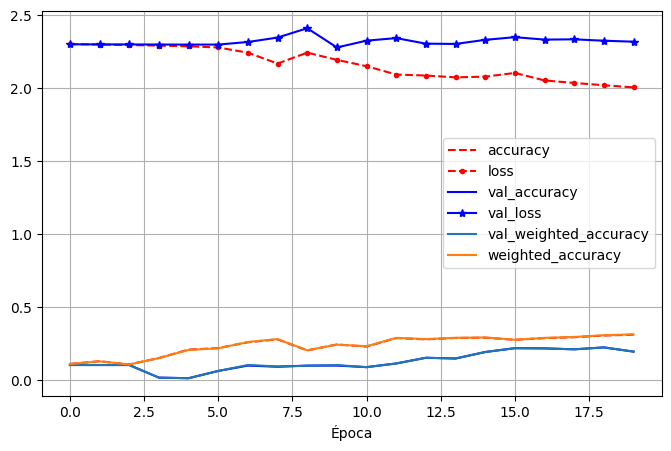

In [29]:
# Visualizacion de la evolucion del entrenamiento
pd.DataFrame(complete_history).plot(
figsize=(8, 5), grid=True, xlabel="Época",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
plt.savefig("evolucion_entrenamiento.pdf")

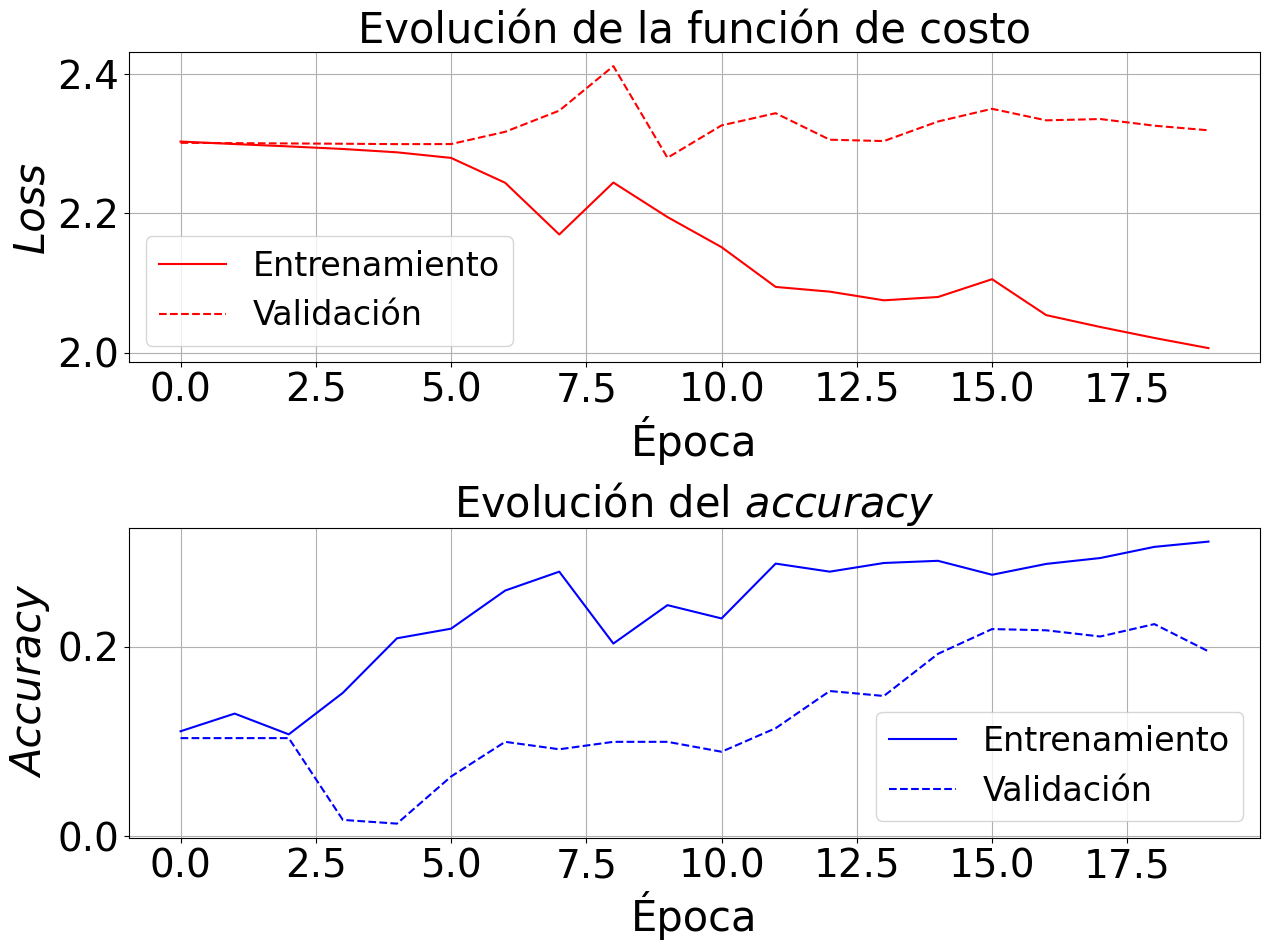

In [30]:
df = pd.DataFrame(complete_history)

# Crear figura con dos subgráficos (uno arriba del otro)
fig, axes = plt.subplots(2, 1, figsize=(12.8, 9.6))

# Gráfico de pérdida (loss y val_loss)
df[['loss', 'val_loss']].plot(ax=axes[0], grid=True, style=["r-", "r--"])
axes[0].set_title("Evolución de la función de costo", fontsize=30)
axes[0].set_xlabel("Época", fontsize=30)
axes[0].set_ylabel("Loss", fontsize=30, style='italic')
axes[0].legend(["Entrenamiento", "Validación"], fontsize=24)
axes[0].tick_params(axis='both', labelsize=28)

# Gráfico de precisión (accuracy y val_accuracy)
df[['accuracy', 'val_accuracy']].plot(ax=axes[1], grid=True, style=["b-", "b--"])
axes[1].set_title("Evolución del $accuracy$", fontsize=30)
axes[1].set_xlabel("Época", fontsize=30)
axes[1].set_ylabel("Accuracy", fontsize=30, style='italic')
axes[1].legend(["Entrenamiento", "Validación"], fontsize=24)
axes[1].tick_params(axis='both', labelsize=28)

# Ajustar diseño y guardar figura
plt.tight_layout()
plt.savefig("evolucion_entrenamiento.pdf")

# Adaptación para hacer los evaluate- obtener resultados
Para ejecutar esta parte tengo que tener el modelo entrenado y los dataset base cargados en memoria. Si el modelo ya está entrenado tengo que ejecutar la celda correspondiente.

## Cálculo de predicciones

In [31]:
# armo batches en los conjuntos para poder realizar predicciones
ds_train_batch = ds_train_base.batch(16)
ds_val_batch = ds_val_base.batch(16)
ds_test_batch = ds_test_base.batch(16)

In [32]:
# # Obtener las predicciones en 1hot
y_pred_train_1hot = model.predict(ds_train_batch)
y_pred_val_1hot = model.predict(ds_val_batch)
y_pred_test_1hot = model.predict(ds_test_batch)

191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step


Se puede ver que las predicciones no quedaron organizadas en batches, pero sí devuelven un vector codificado en one hot.

In [ ]:
def onehot2numerical(y_pred):
  # Convertir de one-hot a clases numéricas las predicciones
  y_clases = tf.argmax(y_pred, axis=-1)
  # Convertir a numpy si es necesario
  y_clases_numpy = y_clases.numpy()
  return y_clases_numpy

y_pred_train = onehot2numerical(y_pred_train_1hot)
y_pred_val = onehot2numerical(y_pred_val_1hot)
y_pred_test = onehot2numerical(y_pred_test_1hot)

## Extracción de etiquetas reales

In [ ]:
def extraer_etiquetas_ds(ds):
  y_train_true_list = []
  # for x, y, z in ds: # dataset_with_classes ds_train
  for x, y, z in ds:
    # print(y.shape)
    y_train_true_list.append(y.numpy())
  return y_train_true_list

y_true_train_list = extraer_etiquetas_ds(ds_train_base)
y_true_val_list = extraer_etiquetas_ds(ds_val_base)
y_true_test_list = extraer_etiquetas_ds(ds_test_base)

In [ ]:
y_true_train_array = np.array(y_true_train_list)
y_true_val_array = np.array(y_true_val_list)
y_true_test_array = np.array(y_true_test_list)

# print(y_true_train_array.shape)

In [ ]:
# Visualizacion de ejemplo
y_true_train_list[2]

0

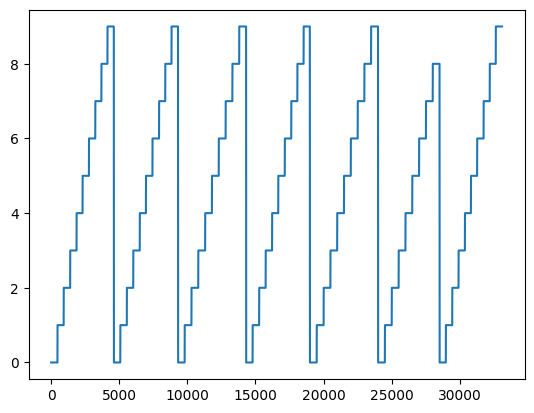

In [ ]:
plt.figure()
plt.plot(y_true_train_array)

### Chequeo si hay nan

In [ ]:
# Chequeo si hay alguna etiqueta nan
nan_indices = np.isnan(y_true_train_array)
np.where(nan_indices==True)[0]

array([], dtype=int64)

In [ ]:
# En los datos crudos
# extraigo datos
def extraer_datos_ds(ds):
  x_train_true_list = []
  for x, y, z in ds: # dataset_with_classes ds_train
    # print(y.shape)
    x_train_true_list.append(x.numpy())
    # print(x.shape)
  return x_train_true_list

x_true_train_list = extraer_datos_ds(ds_train_base)
# y_true_val_list = extraer_etiquetas_ds(ds_val_base)
# y_true_test_list = extraer_etiquetas_ds(ds_test_base)

In [ ]:
x_true_train_array = np.array(x_true_train_list)

# Matrices de confusión

In [ ]:
os.chdir(ruta_experimento) # me situo en el directorio

Accuracy en entrenamiento: 0.9605


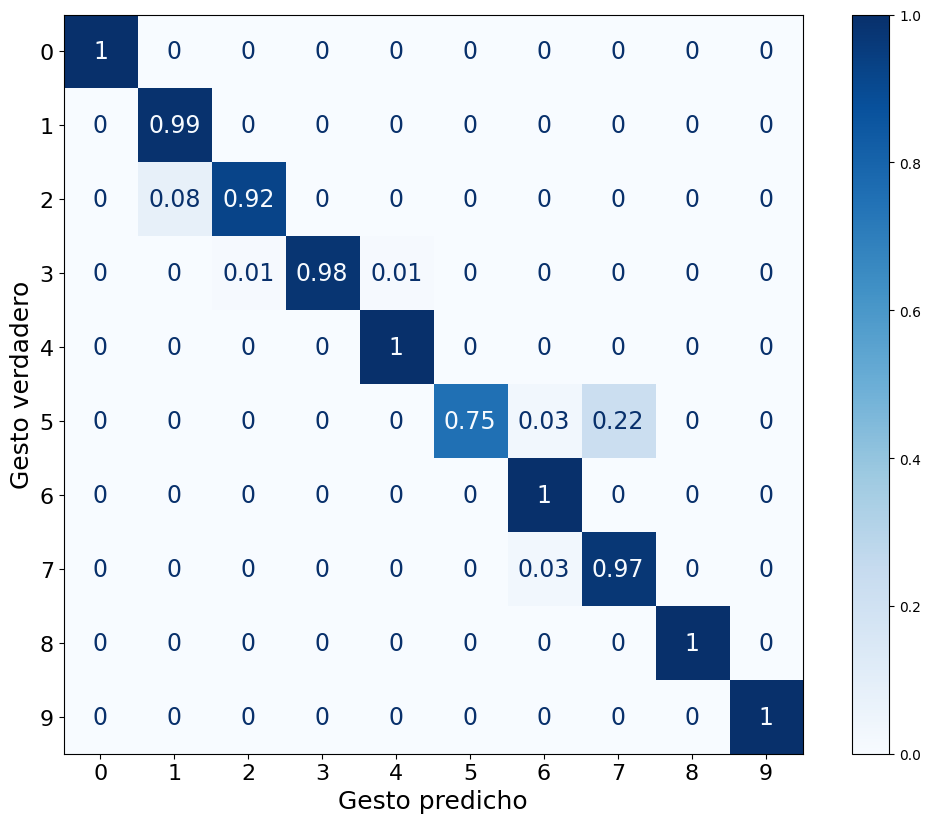

Accuracy en validación: 0.8833


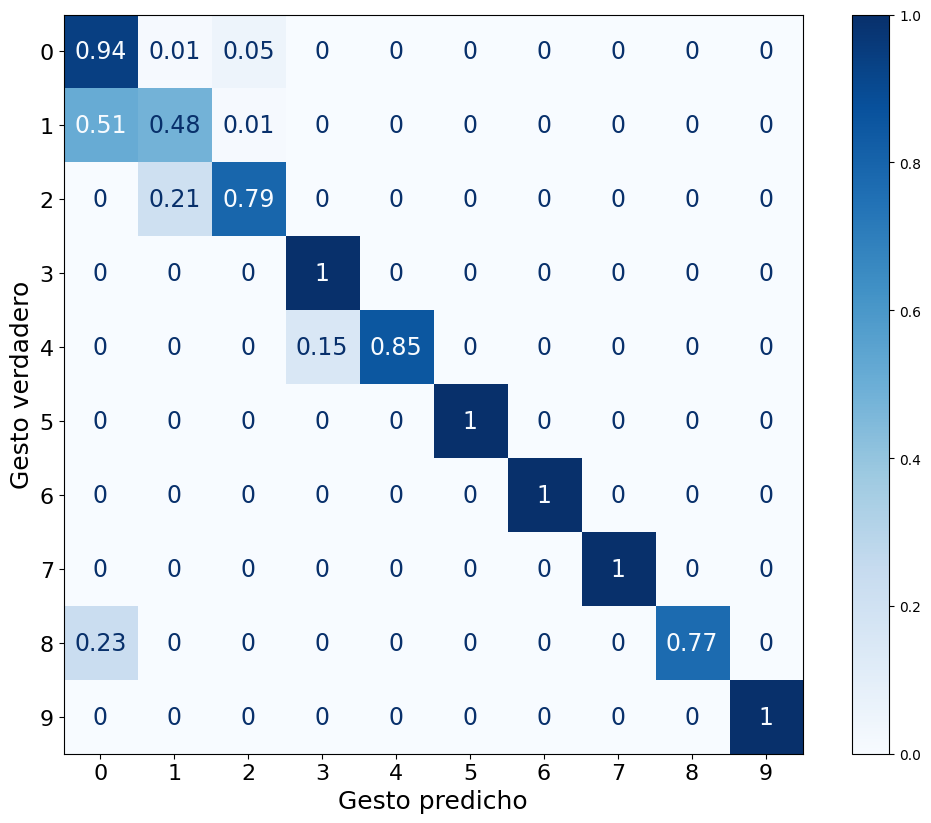

Accuracy en test: 0.8783


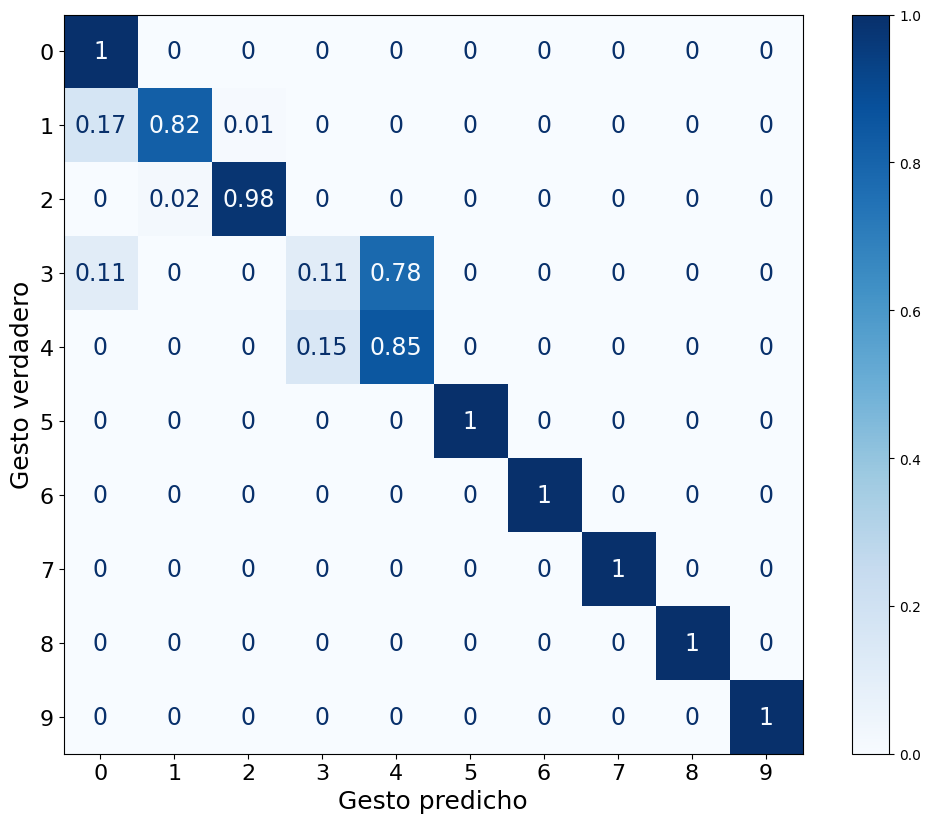

In [ ]:
def calcular_accuracy(y_true, y_pred, nombre_conjunto):
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy en {nombre_conjunto}: {accuracy:.4f}')
    return accuracy
def generar_matriz_confusion_normalizada(y_true, y_pred, title, ruta_guardar, decimales=2):
    # Generar la matriz de confusión normalizada (por clase)
    conf_matrix = confusion_matrix(y_true, y_pred, normalize='true', labels=classes)

    # Redondear la matriz a la cantidad de decimales especificados
    conf_matrix = np.round(conf_matrix, decimals=decimales)

    # Crear la figura con un tamaño personalizado
    fig, ax = plt.subplots(figsize=(12.8, 9.6))  # Ajusta el tamaño según tus necesidades

    # Crear el display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pasar 'ax' para usar el tamaño personalizado

    # Configurar los nombres de los ejes
    disp.ax_.set_xlabel('Gesto predicho', fontsize=18)
    disp.ax_.set_ylabel('Gesto verdadero', fontsize=18)

    # Aumentar el tamaño de las etiquetas de los ejes (tick labels)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Cambiar el tamaño de los números dentro de la matriz
    for text in disp.ax_.texts:
        text.set_fontsize(17)  # Cambia el tamaño de los números dentro de la matriz

    # Guardar la figura
    plt.savefig(ruta_guardar, dpi=600, bbox_inches='tight')  # bbox_inches evita recortes indeseados
    plt.show()

# # Para el conjunto de entrenamiento
accuracy_train = calcular_accuracy(y_true_train_array, y_pred_train, 'entrenamiento')
generar_matriz_confusion_normalizada(y_true_train_array, y_pred_train, 'Confusion Matrix (Normalized) - Training Data', 'train_normalized.png')

# Para el conjunto de validación
accuracy_val = calcular_accuracy(y_true_val_array, y_pred_val, 'validación')
generar_matriz_confusion_normalizada(y_true_val_array, y_pred_val, 'Confusion Matrix (Normalized) - Validation Data', 'val_normalized.png')

# Para el conjunto de test
accuracy_test = calcular_accuracy(y_true_test_array, y_pred_test, 'test')
generar_matriz_confusion_normalizada(y_true_test_array, y_pred_test, 'Confusion Matrix (Normalized) - Test Data','test_normalized.png')


Accuracy en entrenamiento: 0.9605


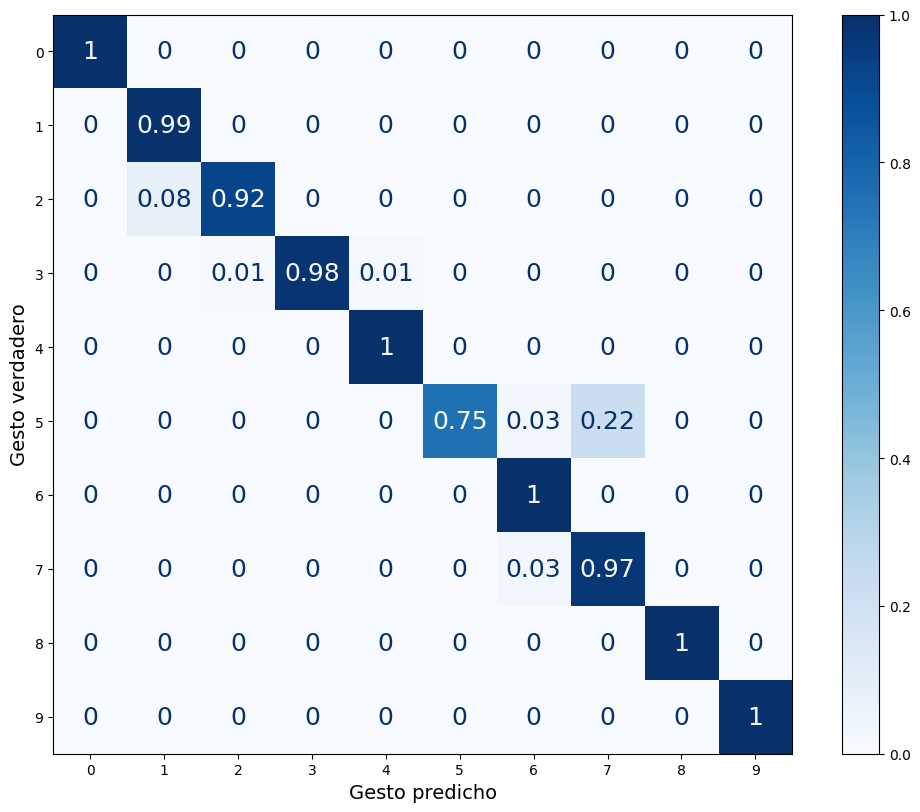

Accuracy en validación: 0.8833


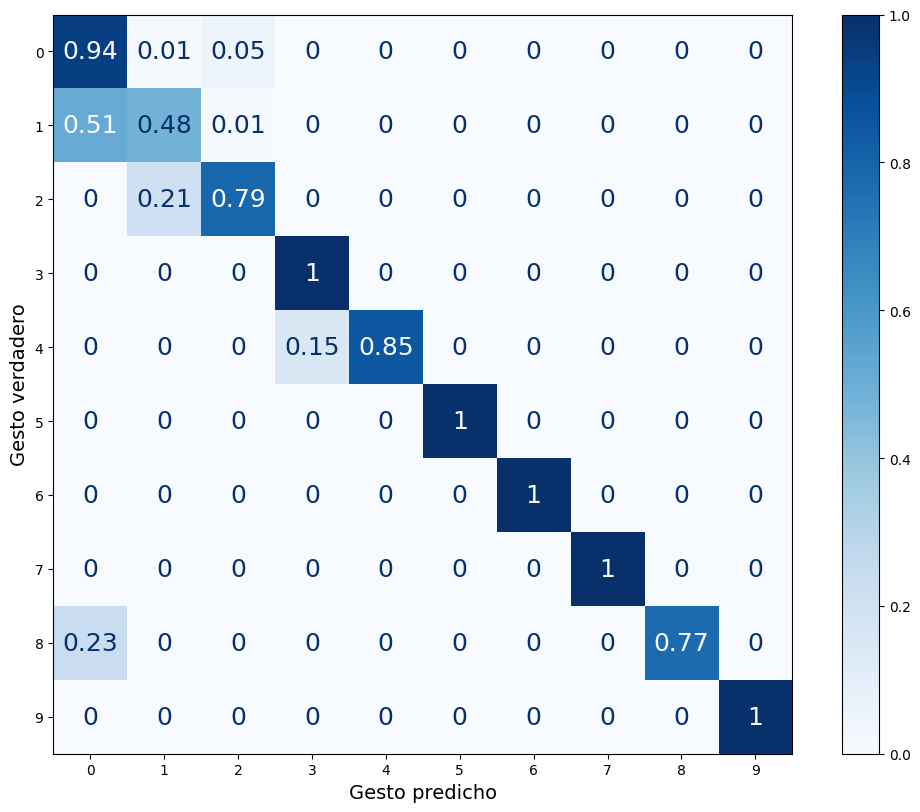

Accuracy en test: 0.8783


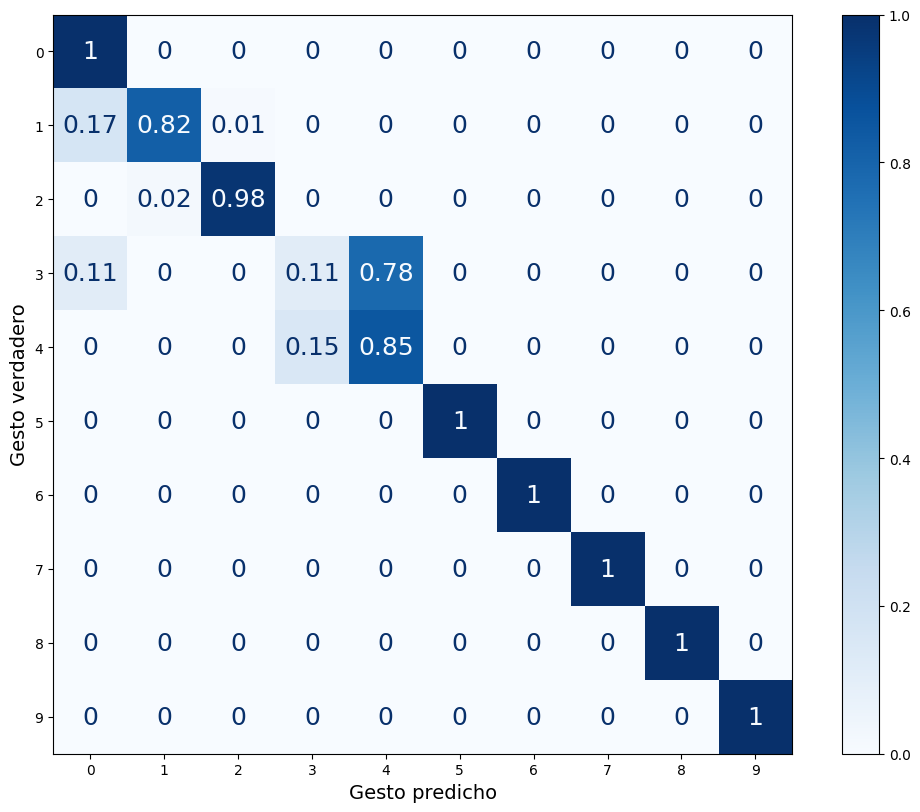

In [ ]:
# Función para generar y guardar la matriz de confusión con proporciones redondeadas
def generar_matriz_confusion_normalizada(y_true, y_pred, title, ruta_guardar, decimales=2):
    # Generar la matriz de confusión normalizada (por clase)
    conf_matrix = confusion_matrix(y_true, y_pred, normalize='true', labels=classes)

    # Redondear la matriz a la cantidad de decimales especificados
    conf_matrix = np.round(conf_matrix, decimals=decimales)

    # Crear el display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # plt.figure(figsize=(12.8, 9.6))
    # Graficar
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_xlabel('Gesto predicho', fontsize=14)
    disp.ax_.set_ylabel('Gesto verdadero', fontsize=14)
    disp.figure_.set_size_inches(12.8, 9.6)
    # plt.title(title)
    for text in disp.ax_.texts:
      text.set_fontsize(18)  # Cambia el tamaño aquí, por ejemplo, 14
    # Guardar la figura
    plt.savefig(ruta_guardar, dpi = 600)
    plt.show()

# Función para calcular y mostrar el accuracy
def calcular_accuracy(y_true, y_pred, nombre_conjunto):
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy en {nombre_conjunto}: {accuracy:.4f}')
    return accuracy

# # Para el conjunto de entrenamiento
accuracy_train = calcular_accuracy(y_true_train_array, y_pred_train, 'entrenamiento')
generar_matriz_confusion_normalizada(y_true_train_array, y_pred_train, 'Confusion Matrix (Normalized) - Training Data', 'train_normalized.png')

# Para el conjunto de validación
accuracy_val = calcular_accuracy(y_true_val_array, y_pred_val, 'validación')
generar_matriz_confusion_normalizada(y_true_val_array, y_pred_val, 'Confusion Matrix (Normalized) - Validation Data', 'val_normalized.png')

# Para el conjunto de test
accuracy_test = calcular_accuracy(y_true_test_array, y_pred_test, 'test')
generar_matriz_confusion_normalizada(y_true_test_array, y_pred_test, 'Confusion Matrix (Normalized) - Test Data','test_normalized.png')


# Guardar experimento en Comet

In [ ]:
joblib.dump(conf_matrix_train, "cm_train_"+nombre_exp+".pkl")
joblib.dump(conf_matrix_val, "cm_val_"+nombre_exp+".pkl")
joblib.dump(conf_matrix_test, "cm_test_"+nombre_exp+".pkl")

['cm_test_GI_estrategia4_sujeto5_opt.pkl']

In [ ]:
# Guardar resumen en una cadena de texto para guardarlo en Comet
stream = io.StringIO()
model.summary(print_fn=lambda x: stream.write(x + '\n'))
summary_str = stream.getvalue()
stream.close()

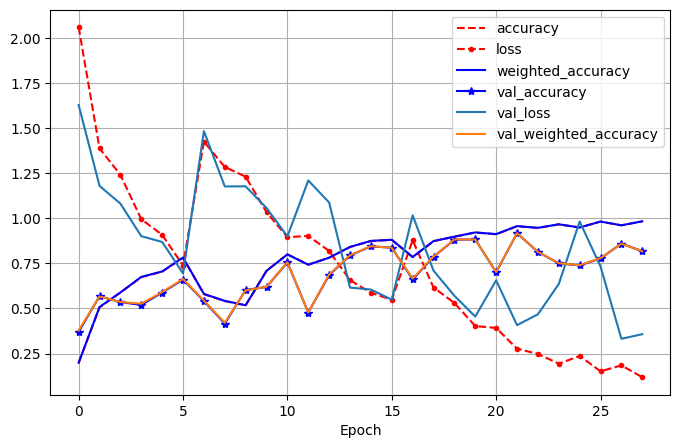

In [ ]:
nombre = nombre_exp
joblib.dump(model, nombre + '.pkl')
pd.DataFrame(complete_history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
plt.savefig("evolucion_entrenamiento.png")

In [ ]:
# API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
              project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
              auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['ronda_GI', 'estrategia5', '10_gestos','seq_vector', 'x_sujeto']) # Tags,'particion_1'

exp.log_metric("test_accuracy_rank", accuracy_test)
exp.log_metric("val_accuracy_rank", accuracy_val)
exp.log_metric("train_accuracy_rank", accuracy_train)

exp.log_parameter("batch_size", BATCH_SIZE)
exp.log_parameter("stride", 5)
exp.log_parameter("largo_secuencia", 650)
exp.log_parameter("stop_epoch", 20)
exp.log_parameter("sample_weight", 0)
exp.log_parameter("porcentaje_label", 100)
exp.log_parameter("cantidad_gestos", 10)
exp.log_parameter("particion_datos", 1)
exp.log_parameter("lr", format(lr, ".8g"))
exp.log_parameter("sujeto", 5)


# # solo si es por sujeto
# exp.log_parameter("sujetos train", ind_train)
# exp.log_parameter("sujetos validacion", ind_val)
# exp.log_parameter("sujetos test", ind_test)

# Guardar la imagen en Comet
exp.log_image("evolucion_entrenamiento.png")

exp.log_image('train.png')
exp.log_image('val.png')
exp.log_image('test.png')

exp.log_image('train_normalized.png')
exp.log_image('val_normalized.png')
exp.log_image('test_normalized.png')

exp.log_asset("cm_train_"+nombre_exp+".pkl")
exp.log_asset("cm_val_"+nombre_exp+".pkl")
exp.log_asset("cm_test_"+nombre_exp+".pkl")

exp.log_text("Estrategia 4 con optimización, por repeticion..\n")   # Comentario del experimento
exp.log_text("Model Summary:\n" + summary_str)
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, keras, tensorflow.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/92872484d95445bda2594816d1955c19

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 